In [1]:
import pandas as pd

import opendatasets as od
od.download("https://www.kaggle.com/datasets/kazanova/sentiment140/data")

Skipping, found downloaded files in "./sentiment140" (use force=True to force download)


In [12]:
# Load your dataset
df = pd.read_csv("sentiment140/training.1600000.processed.noemoticon.csv",encoding = 'latin',header=None)

In [13]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [15]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [16]:
map_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return map_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head(5)

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [17]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
# Text cleaning function
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\s+', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    return text



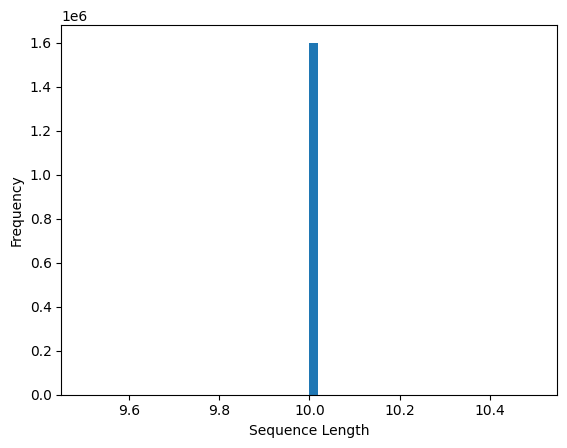

In [19]:
import matplotlib.pyplot as plt

# Calculate sequence lengths
sequence_lengths = [len(seq) for seq in X]

# Plot a histogram of sequence lengths
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()


In [20]:
# Apply text cleaning
df['text'] = df['text'].apply(clean_text)

# Tokenization
max_words = 10000  # Number of unique words to tokenize
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])

# Convert text to sequences
X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen=10)  # Max len based on plot

In [21]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode sentiments
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(df['sentiment'].values.reshape(-1, 1))


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

embedding_dim = 128
lstm_units = 64

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=10))
model.add(LSTM(units=lstm_units))
model.add(Dense(units=2, activation='softmax'))  # 2 output units for binary classification (Negative and Positive)


In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


Epoch 1/5
18000/18000 [==============================] - 257s 14ms/step - loss: 0.4523 - accuracy: 0.7849 - val_loss: 0.4369 - val_accuracy: 0.7968
Epoch 2/5
18000/18000 [==============================] - 254s 14ms/step - loss: 0.4162 - accuracy: 0.8059 - val_loss: 0.4257 - val_accuracy: 0.8017
Epoch 3/5
18000/18000 [==============================] - 254s 14ms/step - loss: 0.3957 - accuracy: 0.8178 - val_loss: 0.4264 - val_accuracy: 0.8025
Epoch 4/5
18000/18000 [==============================] - 255s 14ms/step - loss: 0.3769 - accuracy: 0.8286 - val_loss: 0.4318 - val_accuracy: 0.8006
Epoch 5/5
18000/18000 [==============================] - 253s 14ms/step - loss: 0.3581 - accuracy: 0.8389 - val_loss: 0.4408 - val_accuracy: 0.7972


In [27]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.2f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')


10000/10000 [==============================] - 43s 4ms/step - loss: 0.4383 - accuracy: 0.7985
Test Loss: 0.44
Test Accuracy: 79.85%


In [29]:
# Example: Make predictions on new data
new_texts = ["I love this product!", "This movie is terrible."]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=10)
predictions = model.predict(new_padded_sequences)

# Decode predictions
predicted_labels = encoder.inverse_transform(predictions)
print(predicted_labels)


1/1 [==============================] - 0s 495ms/step
[['Positive']
 ['Negative']]
